In [5]:
from collections import defaultdict
from itertools import combinations

# 1. 一个小函数，计算一个 DNA 串的反向互补
def revcomp(seq: str) -> str:
    comp = {'A':'T','T':'A','C':'G','G':'C'}
    return ''.join(comp[c] for c in reversed(seq))

print(revcomp('ATCG'))

# 2. 建两个索引：正向和倒位
def build_bi_strand_index(reference: str, k: int, d: int):
    """
    返回：
      masks,             # LSH 掩码列表
      idx_pos, idx_neg   # 两个 List[Dict]，分别是正向和倒位索引
    """
    masks = list(combinations(range(k), k - d))
    idx_pos = []  # 正向索引
    idx_neg = []  # 倒位索引（对反向互补建表）
    rc_ref = revcomp(reference)
    
    n=len(reference)

    for mask in masks:
        m_pos = defaultdict(list)
        m_neg = defaultdict(list)
        for i in range(n - k + 1):
            kmer_pos = reference[i:i+k]
            key_pos = hash(tuple(kmer_pos[p] for p in mask))
            m_pos[key_pos].append(i)

            kmer_neg=rc_ref[n-(i+k):n-(i)]
            key_neg = hash(tuple(kmer_neg[p] for p in mask))
            m_neg[key_neg].append(i)
            
            
            
        idx_pos.append(m_pos)
        idx_neg.append(m_neg)

    return masks, idx_pos, idx_neg

# 3. 查 query 时，同一个 k-mer 既在正向，也在倒位里查
def match_bi_strand(query: str, k: int, d: int, masks, idx_pos, idx_neg):
    """
    返回 List[(q_pos, r_pos, strand)]
    strand = +1 (正向) 或 -1 (倒位)
    """
    anchors = []
    anchors_r = []
    for q in range(len(query) - k + 1):
        kmer = query[q:q+k]
        # kmer_rc = revcomp(kmer)
        for mask, m_pos, m_neg in zip(masks, idx_pos, idx_neg):
            key = hash(tuple(kmer[p] for p in mask))
            for r in m_pos.get(key, []):
                anchors.append((q, r))
            for r in m_neg.get(key, []):
                anchors_r.append((q, r))
    # 去重
    return list(set(anchors)), list(set(anchors_r))

# —— 使用示例 —— #




CGAT


In [6]:
# ———————— 使用示例 ————————

# 假设：
# reference = "ACTGATCATGATCGTAGCT"  # 长百万级的字符串
# query     = "ACCGAACATGCTCGGAGAT"      # 待比对字符串
def read_sequence_from_file(path: str) -> str:
    """
    从文本文件读取 DNA 序列：
    - 忽略空行和首尾空白
    - 返回纯净的字符串（只包含 A/C/G/T）
    """
    with open(path, "r") as f:
        # 读取每一行，去掉首尾空白，过滤空行
        lines = [line.strip() for line in f if line.strip()]
    # 将多行拼接成一个连续序列
    return "".join(lines)

# 调用示例
reference = read_sequence_from_file("ref1.txt")
query     = read_sequence_from_file("que1.txt")
k, d      = 11, 2

# 1. 建双链索引
masks, idx_pos, idx_neg = build_bi_strand_index(reference, k, d)

# 2. 匹配
anchors ,anchors_r= match_bi_strand(query, k, d, masks, idx_pos, idx_neg)
print("anchors:", anchors[:10])
print("anchors_r:", anchors_r[:10])
# 每个元素是 (q_pos, r_pos, strand)

print("找到的锚点数量len(anchors)：", len(anchors))
print("部分锚点示例：", anchors[:10])
for i, (q_pos, r_pos) in enumerate(anchors[:10], 1):   #索引从1开始计数
    q_kmer = query[q_pos : q_pos + k]
    r_kmer = reference[r_pos : r_pos + k]
    print(f"{i:2d}. query[{q_pos:4d}:{q_pos+k:4d}] = {q_kmer}    "
          f"| reference[{r_pos:4d}:{r_pos+k:4d}] = {r_kmer} ")

print("找到的锚点数量len(anchors)：", len(anchors_r))
print("部分锚点示例：", anchors_r[:10])
for i, (q_pos, r_pos) in enumerate(anchors_r[:10], 1):   #索引从1开始计数
    q_kmer = query[q_pos : q_pos + k]
    r_kmer = reference[r_pos : r_pos + k]
    print(f"{i:2d}. query[{q_pos:4d}:{q_pos+k:4d}] = {q_kmer}    "
          f"| reference[{r_pos:4d}:{r_pos+k:4d}] = {r_kmer} ")


#超参数
if(len(query)<10000):
    max_err2=1000
    min_len3=0
    min_len4=0
    
else:
    max_err2=6
    min_len3=198
    min_len4=1000
    

anchors: [(788, 838), (774, 674), (130, 380), (1513, 1013), (695, 795), (1820, 1170), (533, 733), (1658, 1108), (247, 147), (1096, 846)]
anchors_r: [(1273, 916), (222, 1244), (969, 770), (963, 726), (2448, 1407), (405, 584), (62, 739), (1175, 874), (1122, 719), (2054, 699)]
找到的锚点数量len(anchors)： 5630
部分锚点示例： [(788, 838), (774, 674), (130, 380), (1513, 1013), (695, 795), (1820, 1170), (533, 733), (1658, 1108), (247, 147), (1096, 846)]
 1. query[ 788: 799] = GTGGCGTTTGC    | reference[ 838: 849] = GTGGCGTTTGC 
 2. query[ 774: 785] = CTAGGGCACGA    | reference[ 674: 685] = CTATGGCACAA 
 3. query[ 130: 141] = TGGGAAATACT    | reference[ 380: 391] = TCCGAAATACT 
 4. query[1513:1524] = TATCTTTCAGC    | reference[1013:1024] = TATCTTTCAGC 
 5. query[ 695: 706] = TTGCCCCCGCG    | reference[ 795: 806] = TTGCCCCCGTG 
 6. query[1820:1831] = CAGCGCCTGCG    | reference[1170:1181] = GAGCGCTTGCG 
 7. query[ 533: 544] = GACGGGTGGCG    | reference[ 733: 744] = GGCGGGTGGCG 
 8. query[1658:1669] = CTAAAGGG

anchor q0=788, r0=838
anchor q1=405, r1=584
TATGACACCAAAAGATCTACCTACAGCCCG
CAGTACTGTAGGTATATCTTTTGGTGTCAT
TATGACACCA  AAAGATCTACC  TACAGCCCG
CAGTACTGTA  GGTATATCTTT  TGGTGTCAT


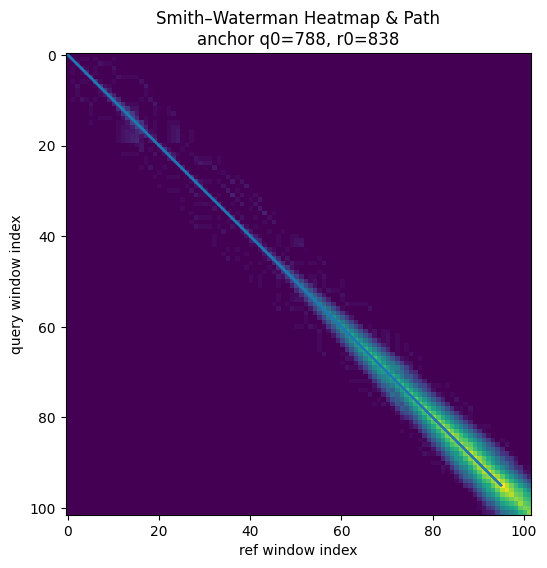

Aligned fragment:
 query[738:832] = GTGGCGTTTGCCCTCCCCCAGCTTGACTACTGTGCTCTAGGGCACGACGGGTGGCGTTTGCCCCCGCGCAGCTCGACTTTTGTGCTCTATGGCAC
 ref  [788:882] = GTGGCGTTTGCCCCCGTGCAGCCCGACTTTTGTACTCTAGTGCACGACGGGTGGCGTTTGCCCCCGCACCGCTCGACTTTTGTGATCTAGGGCAC
Best score: 92


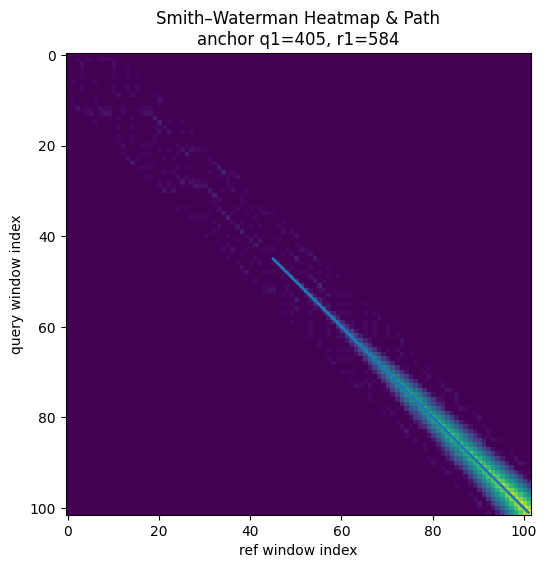

q_st: 400 q_en: 455 r_st: 544 r_en: 599 r_st_r: 1100 r_en_r: 1155
Aligned fragment:
 query[400:455] = CTGTAGGTATATCTTTTGGTGTCATATGAGGGTACTGAACTTGACGACCGCGACCA
 ref  [544:599] = TGGTCGCGGTCGTCAACTTCAGTACGCTCATATGACACCAAAAGATCTACCTACAG
Best score: 91


In [7]:
import numpy as np 
import matplotlib.pyplot as plt





def compute_banded_sw_matrix(ref, query, r0, q0,
                             W=50, band=10,
                             match=2, mismatch=-5, gap=-10):
    """
    本函数返回：
      H:    (n+1)x(m+1) 的得分矩阵
      path: 回溯路径列表 [(i1,j1),...,(ik,jk)]
      q_lo, r_lo: 窗口在原始序列中的左边界
    """
    # 定义窗口
    q_lo = max(0, q0 - W); q_hi = min(len(query), q0 + W + 1)
    r_lo = max(0, r0 - W); r_hi = min(len(ref),   r0 + W + 1)
    n, m = q_hi - q_lo, r_hi - r_lo

    # 初始化
    H = np.zeros((n+1, m+1), dtype=int)
    best_score, bi, bj = 0, 0, 0

    # 填表
    for i in range(1, n+1):
        j_start = max(1, i - band)
        j_end   = min(m, i + band)
        for j in range(j_start, j_end+1):
            sc = match if query[q_lo+i-1] == ref[r_lo+j-1] else mismatch
            diag = H[i-1, j-1] + sc
            up   = H[i-1, j]   + gap
            left = H[i,   j-1] + gap
            H[i, j] = val = max(0, diag, up, left)
            if val > best_score:
                best_score, bi, bj = val, i, j

    # 回溯
    path = []
    i, j = bi, bj
    while i>0 and j>0 and H[i, j] > 0:
        path.append((i, j))
        sc = match if query[q_lo+i-1] == ref[r_lo+j-1] else mismatch
        if H[i, j] == H[i-1, j-1] + sc:
            i, j = i-1, j-1
        elif H[i, j] == H[i-1, j] + gap:
            i -= 1
        else:
            j -= 1
    path.append((i, j))
    path.reverse()
    return H, path, q_lo, r_lo


# 选一个 anchor，比如第 1 个
q0, r0 = anchors[0]
q1, r1 = anchors_r[5]

reference_r=revcomp(reference)
print(f"anchor q0={q0}, r0={r0}")
print(f"anchor q1={q1}, r1={r1}")
print(reference[r1-10:r1+20])
print(query[q1-10:q1+20])
print(reference[r1-10:r1]+'  '+reference[r1:r1+11]+'  '+reference[r1+11:r1+20])
print(query[q1-10:q1]+'  '+query[q1:q1+11]+'  '+query[q1+11:q1+20])

len_ref=len(reference) 


r1_r=(len_ref-1)-(r1+10)

# 计算矩阵和路径
H, path, q_lo, r_lo = compute_banded_sw_matrix(reference, query, r0, q0)

# 可视化得分矩阵和回溯路径
plt.figure(figsize=(6, 6))
plt.imshow(H, aspect='auto')
ys, xs = zip(*path)
plt.plot(xs, ys, linewidth=2)
plt.title(f"Smith–Waterman Heatmap & Path\nanchor q0={q0}, r0={r0}")
plt.xlabel("ref window index")
plt.ylabel("query window index")
plt.show()

# 将回溯结果映射回原始序列坐标并打印
i0, j0 = path[0]
bi, bj = path[-1]
q_st = q_lo + i0
q_en = q_lo + bi - 1
r_st = r_lo + j0
r_en = r_lo + bj - 1

print("Aligned fragment:")
print(f" query[{q_st}:{q_en}] = {query[q_st:q_en+1]}")
print(f" ref  [{r_st}:{r_en}] = {reference[r_st:r_en+1]}")
print("Best score:", H.max())

#_____________________________________________________________________________________



H, path, q_lo, r_lo = compute_banded_sw_matrix(reference_r, query, r1_r, q1)

# 可视化得分矩阵和回溯路径
plt.figure(figsize=(6, 6))
plt.imshow(H, aspect='auto')
ys, xs = zip(*path)
plt.plot(xs, ys, linewidth=2)
plt.title(f"Smith–Waterman Heatmap & Path\nanchor q1={q1}, r1={r1}")
plt.xlabel("ref window index")
plt.ylabel("query window index")
plt.show()

# 将回溯结果映射回原始序列坐标并打印
i0, j0 = path[0]
bi, bj = path[-1]
q_st = q_lo + i0
q_en = q_lo + bi - 1
r_st_r = r_lo + j0
r_en_r = r_lo + bj - 1

r_st=len_ref-1-r_en_r
r_en=len_ref-1-r_st_r
print("q_st:", q_st, "q_en:", q_en, "r_st:", r_st, "r_en:", r_en,"r_st_r:", r_st_r,"r_en_r:", r_en_r)

print("Aligned fragment:")
print(f" query[{q_st}:{q_en}] = {query[q_st:q_en+1]}")
print(f" ref  [{r_st}:{r_en}] = {reference[r_st:r_en+1]}")
print("Best score:", H.max())


In [8]:
import numpy as np
from tqdm import tqdm
def compute_banded_sw_simple(ref, query, r0, q0,
                             W=100, band=10,
                             match=2, mismatch=-5, gap=-10):
    """
    带宽限制的 Smith-Waterman 局部对齐——简洁版
    输入:
      ref, query: DNA 序列
      r0, q0: 种子锚点在 ref/query 上的位置
      W: 窗口半宽度，band: 带宽优化
      match/mismatch/gap: 计分
    输出:
      (q_start, q_end, r_start, r_end, best_score)
    """
    # 1. 定义局部对齐窗口
    q_lo = max(0, q0 - W); q_hi = min(len(query), q0 + W + 1)
    r_lo = max(0, r0 - W); r_hi = min(len(ref),   r0 + W + 1)
    n, m = q_hi - q_lo, r_hi - r_lo

    # 2. DP 矩阵，只存两行滚动优化也可以，这里为了回溯保留全矩阵
    H = np.zeros((n+1, m+1), dtype=int)
    best, bi, bj = 0, 0, 0

    # 3. 填表
    for i in range(1, n+1):
        j0 = max(1, i - band); j1 = min(m, i + band)
        for j in range(j0, j1+1):
            s = match if query[q_lo+i-1] == ref[r_lo+j-1] else mismatch
            v = max(0,
                    H[i-1, j-1] + s,
                    H[i-1, j]   + gap,
                    H[i,   j-1] + gap)
            H[i, j] = v
            if v > best:
                best, bi, bj = v.item(), i, j

    # 4. 回溯到局部起点
    i, j = bi, bj
    while i>0 and j>0 and H[i, j] > 0:
        # 优先判断对角线
        if H[i, j] == H[i-1, j-1] + (match if query[q_lo+i-1]==ref[r_lo+j-1] else mismatch):
            i, j = i-1, j-1
        elif H[i, j] == H[i-1, j] + gap:
            i -= 1
        else:
            j -= 1

    # 5. 映射到全局坐标并返回
    q_start = q_lo + i
    q_end   = q_lo + bi - 1
    r_start = r_lo + j
    r_end   = r_lo + bj - 1
    return (q_start, q_end, r_start, r_end, best)

fragments = []
for q0, r0 in tqdm(anchors, desc="Forward anchors", unit="anch"):
    frag = compute_banded_sw_simple(reference, query, r0, q0,
                                    W=100, band=10,
                                    match=2, mismatch=-5, gap=-10)
    if frag:
        fragments.append(frag + (1,))

len_ref = len(reference_r)
fragments_r = []
for q1, r1 in tqdm(anchors_r, desc="Reverse anchors", unit="anch"):
    # 把反向坐标映回正向
    r1_r = (len_ref - 1) - (r1 + k)
    frag = compute_banded_sw_simple(reference_r, query, r1_r, q1,
                                    W=100, band=10,
                                    match=2, mismatch=-5, gap=-10)
    if frag:
        lst = list(frag)
        # 把局部坐标再映射回原 reference
        r_start_r, r_end_r = lst[2], lst[3]
        lst[2] = len_ref - 1 - r_end_r
        lst[3] = len_ref - 1 - r_start_r
        fragments_r.append(tuple(lst) + (-1,))
        
        
print(len(fragments))
print(fragments[:10])

print(len(fragments_r))
print(fragments_r[:10])




#关键参数：W，band


Reverse anchors: 100%|██████████| 1329/1329 [00:07<00:00, 185.97anch/s]

5630
[(688, 832, 738, 882, 157, 1), (700, 874, 600, 774, 217, 1), (99, 150, 349, 400, 34, 1), (1500, 1613, 1000, 1113, 200, 1), (595, 795, 695, 895, 262, 1), (1749, 1897, 1099, 1247, 74, 1), (507, 633, 707, 833, 135, 1), (1721, 1756, 1171, 1206, 44, 1), (202, 269, 102, 169, 45, 1), (1002, 1136, 752, 886, 130, 1)]
1329
[(1200, 1299, 900, 999, 193, -1), (272, 278, 1198, 1204, 14, -1), (900, 997, 752, 849, 98, -1), (900, 999, 700, 799, 172, -1), (2438, 2443, 1430, 1435, 12, -1), (400, 500, 499, 599, 167, -1), (8, 11, 842, 845, 8, -1), (1175, 1185, 874, 884, 15, -1), (1124, 1132, 719, 727, 18, -1), (2054, 2067, 696, 709, 21, -1)]


In [9]:

import numpy as np
from numba import njit
import edlib


def get_rc(s):
    map_dict = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G', 'N': 'N'}
    l = []
    for c in s:
        l.append(map_dict[c])
    l = l[::-1]
    return ''.join(l)
def rc(s):
    map_dict = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G', 'N': 'N'}
    l = []
    for c in s:
        l.append(map_dict[c])
    l = l[::-1]
    return ''.join(l)

def seq2hashtable_multi_test(refseq, testseq, kmersize=15, shift = 1):
    rc_testseq = get_rc(testseq)
    testseq_len = len(testseq)
    local_lookuptable = dict()
    skiphash = hash('N'*kmersize)
    for iloc in range(0, len(refseq) - kmersize + 1, 1):
        hashedkmer = hash(refseq[iloc:iloc+kmersize])
        if(skiphash == hashedkmer):
            continue
        if(hashedkmer in local_lookuptable):

            local_lookuptable[hashedkmer].append(iloc)
        else:
            local_lookuptable[hashedkmer] = [iloc]
    iloc = -1
    readend = testseq_len-kmersize+1
    one_mapinfo = []
    preiloc = 0
    while(True):
   
        iloc += shift
        if(iloc >= readend):
            break

        #if(hash(testseq[iloc: iloc + kmersize]) == hash(rc_testseq[-(iloc + kmersize): -iloc])):
            #continue
 
        hashedkmer = hash(testseq[iloc: iloc + kmersize])
        if(hashedkmer in local_lookuptable):

            for refloc in local_lookuptable[hashedkmer]:

                one_mapinfo.append((iloc, refloc, 1, kmersize))



        hashedkmer = hash(rc_testseq[-(iloc + kmersize): -iloc])
        if(hashedkmer in local_lookuptable):
            for refloc in local_lookuptable[hashedkmer]:
                one_mapinfo.append((iloc, refloc, -1, kmersize))
        preiloc = iloc

    

    return np.array(one_mapinfo)

def get_points(tuples_str):
    data = []
    num = 0
    for c in tuples_str:
        if(ord('0') <= c <= ord('9')):
            num = num * 10 + c - ord('0')
        elif(ord(',') == c):
            data.append(num)
            num = 0
    if(num != 0):
        data.append(num)
    return data

def calculate_distance(ref, query, ref_st, ref_en, query_st, query_en):
    A = ref[ref_st: ref_en]
    a = query[query_st: query_en]
    _a = rc(query[query_st: query_en])
    return min(edlib.align(A, a)['editDistance'], edlib.align(A, _a)['editDistance'])

def get_first(x):
    return x[0]


def calculate_value(tuples_str, ref, query):  

    slicepoints = np.array(get_points(tuples_str.encode()))
    if(len(slicepoints) > 0 and len(slicepoints) % 4 == 0):
        print(len(slicepoints))
        editdistance = 0
        aligned = 0
        preend = 0
        points = np.array(slicepoints).reshape((-1, 4)).tolist()
        print(points)
        points.sort(key=get_first)
        for onetuple in points:
            query_st, query_en, ref_st, ref_en = onetuple
            if(preend > query_st):
                print(f"overlapped!")
                return 0
            if(query_en - query_st < 30):
                print(f"query_st:{query_st}, query_en:{query_en}, ref_st:{ref_st}, ref_en:{ref_en}"+"too short!")
                continue
            preend = query_en
            if((calculate_distance(ref, query, ref_st, ref_en, query_st, query_en)/len(query[query_st:query_en])) > 0.1):
                print(f"query_st:{query_st}, query_en:{query_en}, ref_st:{ref_st}, ref_en:{ref_en}"+f"too different!:cal_dis:{calculate_distance(ref, query, ref_st, ref_en, query_st, query_en)}, aligned:{len(query[query_st:query_en])}")
                continue
            editdistance += calculate_distance(ref, query, ref_st, ref_en, query_st, query_en)
            aligned += len(query[query_st:query_en])
            print(f"query_st:{query_st}, query_en:{query_en}, ref_st:{ref_st}, ref_en:{ref_en}:cal_dis:{calculate_distance(ref, query, ref_st, ref_en, query_st, query_en)}, aligned:{len(query[query_st:query_en])}")
            
        print(f"editdistance:{editdistance}, aligned:{aligned}")
        return max(aligned - editdistance, 0)
    else:
        print(len(slicepoints))
        return 0


In [10]:
def filter_fragments1(fragments, ref, query,
                     min_len=30,
                     max_err_rate=0.10):
    print("过滤片段")
    print("过滤前数量：" + str(len(fragments)))
    out = []
    cnt1=0
    cnt2=0
    for qs, qe, rs, re, sc, strand in fragments:
        L = qe - qs + 1
        ed = calculate_distance(ref, query, rs, re, qs, qe)
        if L < min_len:
            cnt1+=1
            continue
        
        print(f"rs:{rs}, re:{re}, qs:{qs}, qe:{qe}, L:{L}, ed:{ed}")
        if ed / L > max_err_rate:
            # print(f"过滤掉rs:{rs}, re:{re}, qs:{qs}, qe:{qe},因为{ed / L}>{max_err_rate}")
            cnt2+=1
            continue
        # 重新计算节点权重：对齐长度 - 编辑距离
        weight = L - ed
        out.append((qs, qe, rs, re, weight, strand))
    print("过滤后数量：" + str(len(out)))
    print("after filter fragments:",out)
    print(f"过滤完成,由于 L < min_len 的数量：{cnt1},由于 ed / L > max_err_rate 的数量：{cnt2}")
    return out




fragments_all = fragments + fragments_r
# print("fragments:",fragments)
# print("fragments_r:",fragments_r)
# print("fragments_all:",fragments_all)

filtered = filter_fragments1(fragments_all, reference, query,
                            min_len=30, max_err_rate=0.10)

# plt.figure(figsize=(8,4))
# # for qs, qe, rs, re, sc, sgn in filtered:
# for qs, qe, rs, re, sc, sgn in filtered:
#     if sgn == 1:
#         plt.plot([qs, qe], [rs, re], lw=2)
#     else:
#         # 倒序片段要画反向连线：q从小到大，ref从大到小
#         plt.plot([qs, qe], [re, rs], lw=2)

# plt.xlabel("Query index")
# plt.ylabel("Reference index")
# plt.title("Chained Alignment Fragments")
# plt.show()

过滤片段
过滤前数量：6959
rs:738, re:882, qs:688, qe:832, L:145, ed:19
rs:600, re:774, qs:700, qe:874, L:175, ed:19
rs:349, re:400, qs:99, qe:150, L:52, ed:10
rs:1000, re:1113, qs:1500, qe:1613, L:114, ed:4
rs:695, re:895, qs:595, qe:795, L:201, ed:20
rs:1099, re:1247, qs:1749, qe:1897, L:149, ed:32
rs:707, re:833, qs:507, qe:633, L:127, ed:17
rs:1171, re:1206, qs:1721, qe:1756, L:36, ed:4
rs:102, re:169, qs:202, qe:269, L:68, ed:13
rs:752, re:886, qs:1002, qe:1136, L:135, ed:20
rs:1099, re:1247, qs:1749, qe:1897, L:149, ed:32
rs:402, re:500, qs:1402, qe:1500, L:99, ed:5
rs:650, re:803, qs:1000, qe:1153, L:154, ed:22
rs:800, re:900, qs:1000, qe:1100, L:101, ed:16
rs:756, re:900, qs:606, qe:750, L:145, ed:19
rs:671, re:799, qs:771, qe:899, L:129, ed:6
rs:601, re:779, qs:601, qe:779, L:179, ed:17
rs:1206, re:1342, qs:1656, qe:1792, L:137, ed:28
rs:1000, re:1117, qs:1500, qe:1617, L:118, ed:4
rs:600, re:699, qs:800, qe:899, L:100, ed:14
rs:1171, re:1269, qs:1721, qe:1819, L:99, ed:17
rs:621, re:733

In [12]:
def filter_fragments2(fragments, ref, query,
                     min_len=30,
                     max_err=6):
    print("过滤片段")
    print("过滤前数量：" + str(len(fragments)))
    out = []
    cnt1=0
    cnt2=0
    for qs, qe, rs, re, sc, strand in fragments:
        L = qe - qs + 1
        ed = calculate_distance(ref, query, rs, re, qs, qe)
        if L < min_len:
            cnt1+=1
            continue
        
        print(f"rs:{rs}, re:{re}, qs:{qs}, qe:{qe}, L:{L}, ed:{ed}")
        if ed > max_err:
            print(f"过滤掉rs:{rs}, re:{re}, qs:{qs}, qe:{qe},因为{ed}>{max_err}")
            cnt2+=1
            continue
        # 重新计算节点权重：对齐长度 - 编辑距离
        weight = L - ed
        out.append((qs, qe, rs, re, weight, strand))
    print("过滤后数量：" + str(len(out)))
    print("after filter fragments:",out)
    print(f"过滤完成,由于 L < min_len 的数量：{cnt1},由于 ed  max_err 的数量：{cnt2}")
    return out


filtered2 = filter_fragments2(filtered, reference, query,
                            min_len=30, max_err=max_err2)
# filtered2 = filter_fragments2(filtered, reference, query,
#                             min_len=30, max_err=6)

过滤片段
过滤前数量：2214
rs:1000, re:1113, qs:1500, qe:1613, L:114, ed:4
rs:695, re:895, qs:595, qe:795, L:201, ed:20
rs:402, re:500, qs:1402, qe:1500, L:99, ed:5
rs:671, re:799, qs:771, qe:899, L:129, ed:6
rs:601, re:779, qs:601, qe:779, L:179, ed:17
rs:1000, re:1117, qs:1500, qe:1617, L:118, ed:4
rs:117, re:300, qs:117, qe:300, L:184, ed:10
rs:402, re:500, qs:1402, qe:1500, L:99, ed:5
rs:1166, re:1297, qs:1666, qe:1797, L:132, ed:13
rs:601, re:784, qs:501, qe:684, L:184, ed:6
rs:801, re:854, qs:501, qe:554, L:54, ed:5
rs:704, re:899, qs:1004, qe:1199, L:196, ed:9
rs:1107, re:1199, qs:1807, qe:1899, L:93, ed:1
rs:184, re:300, qs:184, qe:300, L:117, ed:7
rs:1499, re:1641, qs:2299, qe:2441, L:143, ed:6
rs:771, re:899, qs:1071, qe:1199, L:129, ed:7
rs:0, re:180, qs:0, qe:180, L:181, ed:4
rs:671, re:799, qs:771, qe:899, L:129, ed:6
rs:1000, re:1117, qs:1500, qe:1617, L:118, ed:4
rs:47, re:247, qs:47, qe:247, L:201, ed:9
rs:1573, re:1699, qs:2373, qe:2499, L:127, ed:4
rs:1107, re:1199, qs:1807, qe:

In [13]:
def filter_fragments3(fragments, ref, query,
                     min_len=30,
                     max_err=6):
    print("过滤片段")
    print("过滤前数量：" + str(len(fragments)))
    out = []
    cnt1=0
    cnt2=0
    for qs, qe, rs, re, sc, strand in fragments:
        L = qe - qs + 1
        ed = calculate_distance(ref, query, rs, re, qs, qe)
        if L < min_len:
            cnt1+=1
            continue

        weight = L - ed
        out.append((qs, qe, rs, re, weight, strand))
    print("过滤后数量：" + str(len(out)))
    print("after filter fragments:",out)
    print(f"过滤完成,由于 L < min_len 的数量：{cnt1}")
    return out


# filtered3 = filter_fragments3(filtered2, reference, query,
#                             min_len=198, max_err=6)
filtered3 = filter_fragments3(filtered2, reference, query,
                            min_len=min_len3, max_err=6)



过滤片段
过滤前数量：2214
过滤后数量：2214
after filter fragments: [(1500, 1613, 1000, 1113, 110, 1), (595, 795, 695, 895, 181, 1), (1402, 1500, 402, 500, 94, 1), (771, 899, 671, 799, 123, 1), (601, 779, 601, 779, 162, 1), (1500, 1617, 1000, 1117, 114, 1), (117, 300, 117, 300, 174, 1), (1402, 1500, 402, 500, 94, 1), (1666, 1797, 1166, 1297, 119, 1), (501, 684, 601, 784, 178, 1), (501, 554, 801, 854, 49, 1), (1004, 1199, 704, 899, 187, 1), (1807, 1899, 1107, 1199, 92, 1), (184, 300, 184, 300, 110, 1), (2299, 2441, 1499, 1641, 137, 1), (1071, 1199, 771, 899, 122, 1), (0, 180, 0, 180, 177, 1), (771, 899, 671, 799, 123, 1), (1500, 1617, 1000, 1117, 114, 1), (47, 247, 47, 247, 192, 1), (2373, 2499, 1573, 1699, 123, 1), (1807, 1899, 1107, 1199, 92, 1), (1598, 1699, 1298, 1399, 96, 1), (164, 300, 164, 300, 130, 1), (0, 121, 0, 121, 121, 1), (2299, 2447, 1499, 1647, 143, 1), (1300, 1399, 900, 999, 95, 1), (1077, 1199, 777, 899, 116, 1), (2314, 2499, 1514, 1699, 179, 1), (501, 603, 601, 703, 98, 1), (53, 253, 

过滤片段
过滤前数量：23
过滤后数量：23
after filter fragments: [(1500, 1617, 1000, 1117, 1), (1666, 1801, 1166, 1301, 1), (1855, 1997, 1355, 1497, 1), (282, 399, 382, 499, 1), (501, 800, 601, 900, 1), (1402, 1500, 402, 500, 1), (700, 899, 600, 799, 1), (0, 300, 0, 300, 1), (601, 895, 601, 895, 1), (501, 554, 801, 854, 1), (1000, 1199, 700, 899, 1), (1598, 1699, 1298, 1399, 1), (1807, 1899, 1107, 1199, 1), (2299, 2499, 1499, 1699, 1), (1300, 1399, 900, 999, 1), (768, 899, 618, 749, 1), (856, 898, 606, 648, 1), (1002, 1050, 752, 800, 1), (507, 548, 707, 748, 1), (768, 832, 818, 882, 1), (1200, 1299, 900, 999, -1), (900, 999, 700, 799, -1), (400, 500, 499, 599, -1)]
过滤完成,由于 L < min_len 的数量：0
len(pre_ans): 23
合并后得到的区间：
  query[1500:1617]  ↔  ref[1000:1117]
  query[1666:1801]  ↔  ref[1166:1301]
  query[1855:1997]  ↔  ref[1355:1497]
  query[282:399]  ↔  ref[382:499]
  query[501:800]  ↔  ref[601:900]
  query[1402:1500]  ↔  ref[402:500]
  query[700:899]  ↔  ref[600:799]
  query[0:300]  ↔  ref[0:300]
  query[6

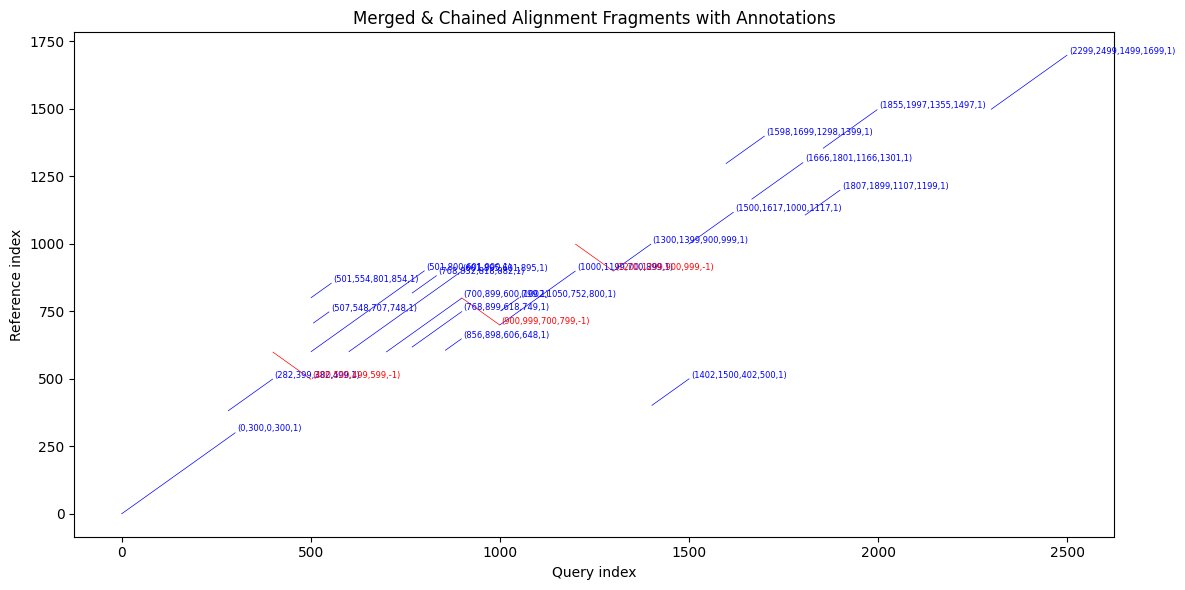

In [14]:
from collections import defaultdict
def merge_aligned_fragments(fragments):
    groups = defaultdict(list)
    # 1) 按 strand 和 offset 分组
    for qs, qe, rs, re, sc, strand in fragments:
        offset = rs - qs if strand==1 else (rs + qe)  # 对逆向，这个 offset 使得 re + qs = const
        groups[(strand, offset)].append((qs, qe))

    merged = []
    # 2) 对每组里的 intervals 合并重叠或相接
    for (strand, offset), intervals in groups.items():
        intervals.sort()
        cur_s, cur_e = intervals[0]
        for s, e in intervals[1:]:
            if s <= cur_e + 1:         # 重叠或相接
                cur_e = max(cur_e, e)
            else:
                # 把上一段输出
                if strand==1:
                    rs, re = cur_s + offset, cur_e + offset
                else:
                    # 逆向：rs/re 距离 qs/ qe 保持反向关系
                    re = offset - cur_s
                    rs = offset - cur_e
                merged.append((cur_s, cur_e, rs, re, strand))
                cur_s, cur_e = s, e

        # 最后一段
        if strand==1:
            rs, re = cur_s + offset, cur_e + offset
        else:
            re = offset - cur_s
            rs = offset - cur_e
        merged.append((cur_s, cur_e, rs, re, strand))

    return merged


def filter_fragments4(fragments, ref, query,
                     min_len=30,
                     max_err=6):
    print("过滤片段")
    print("过滤前数量：" + str(len(fragments)))
    out = []
    cnt1=0
    cnt2=0
    for qs, qe, rs, re, strand in fragments:
        L = qe - qs + 1
        ed = calculate_distance(ref, query, rs, re, qs, qe)
        if L < min_len:
            cnt1+=1
            continue

        weight = L - ed
        out.append((qs, qe, rs, re, strand))
    print("过滤后数量：" + str(len(out)))
    print("after filter fragments:",out)
    print(f"过滤完成,由于 L < min_len 的数量：{cnt1}")
    return out




merged0 = merge_aligned_fragments(filtered3)

# merged = filter_fragments4(merged0, reference, query,
#                             min_len=1000, max_err=6)
merged = filter_fragments4(merged0, reference, query,
                            min_len=min_len4, max_err=6)




pre_ans = []
for qs, qe, rs, re, strand in merged:
    pre_ans.append((qs, qe, rs, re,strand))
    
print("len(pre_ans):"    , len(pre_ans))
# print(pre_ans)



print("合并后得到的区间：")
for qs, qe, rs, re, strand in merged:
    print(f"  query[{qs}:{qe}]  ↔  ref[{rs}:{re}]")

plt.figure(figsize=(12, 6))
for qs, qe, rs, re, strand in merged:
    if strand == 1:
        x_vals = [qs, qe]
        y_vals = [rs, re]
        color = 'b'
    else:
        x_vals = [qs, qe]
        y_vals = [re, rs]  # 反向时交换
        color = 'r'
    plt.plot(x_vals, y_vals, color=color, lw=0.5)
    # 在每条线的末端标注其元组
    label = f"({qs},{qe},{rs},{re},{strand})"
    plt.text(x_vals[1] + 5, y_vals[1] + 5, label, fontsize=6, color=color)

plt.xlabel("Query index")
plt.ylabel("Reference index")
plt.title("Merged & Chained Alignment Fragments with Annotations")
plt.tight_layout()
plt.show()


In [ ]:




def link_promote(reference,query,pre_ans):
    tag=0
    print("pre_ans:",pre_ans)
    true_ans=[]
    cnt=0
    while(1):
        cnt+=1
        print(f"第{cnt}次循环：")
        
        choices=[]
        for qs, qe, rs, re ,strand in pre_ans:
            if tag>=qs and tag<qe:
                choices.append((qs,qe,rs,re,strand))
                # print("choices:",choices)
        print(f"此时rs<=tag<re的choices:{choices}")
        if(len(choices)>0):
            best=max(choices,key=lambda x:x[1]-tag)
            qs,qe,rs,re,strand=best
            
            if(cnt==1):
                true_ans.append(best)
                tag=qe
                print(f"此时best:{best},tag:{tag}")
                continue
                
            
            min_score=10000000
            print(f"qs:{qs},tag:{tag}")
            for div in range(qs,tag):
                #修改前一个，末尾
                qs11,qe11,rs11,re11,strand11=true_ans[-1]
                if strand11==1:
                    qs1=qs11
                    qe1=div
                    rs1=rs11
                    re1=rs1+qe1-qs1
                else:
                    qs1=qs11
                    qe1=div
                    re1=re11
                    rs1=qs1+re1-qe1
                qs22,qe22,rs22,re22,strand22=best
                if strand22==1:
                    qs2=div
                    qe2=qe22+1
                    re2=re22+1
                    rs2=re2+qs2-qe2
                else:
                    qs2=div
                    qe2=qe22+1
                    rs2=rs22
                    re2=rs2+qe2-qs2     
                score=calculate_distance(reference, query, rs1, re1, qs1, qe1)+calculate_distance(reference, query, rs2, re2, qs2, qe2)
                print(f"qs1:{qs1},qe1:{qe1},rs1:{rs1},re1:{re1}     ,qs2:{qs2},qe2:{qe2},rs2:{rs2},re2:{re2},    score:{score}")
                if score<min_score:
                    min_score=score
                    best_div=div
                    print(f"此时best_div:{best_div},score:{score}")
            
            qs11,qe11,rs11,re11,strand11=true_ans[-1]
            del true_ans[-1]
            if strand11==1:
                qs1=qs11
                qe1=best_div
                rs1=rs11
                re1=rs1+qe1-qs1
            else:
                qs1=qs11
                qe1=best_div
                re1=re11
                rs1=qs1+re1-qe1
            qs22,qe22,rs22,re22,strand22=best
            if strand22==1:
                qs2=best_div
                qe2=qe22+1
                re2=re22+1
                rs2=re2+qs2-qe2
            else:
                qs2=best_div
                qe2=qe22+1
                rs2=rs22
                re2=rs2+qe2-qs2
            true_ans.append((qs1,qe1,rs1,re1,strand11))
            true_ans.append((qs2,qe2,rs2,re2,strand22))
            
            
            
            
            

            tag=qe2
            print(f"此时best:{best},tag:{tag}")
            
        else :
            print("此时没有rs<=tag<re的choices")
            for qs,qe,rs,re,strand in pre_ans:
                if qs>tag:
                    choices.append((qs,qe,rs,re,strand))
            print(f"此时rs>tag的choices:{choices}")
            if(len(choices)>0):
                best=min(choices,key=lambda x:x[0])
                qs,qe,rs,re,strand=best
                if strand==1:
                    qs1=tag
                    qe1=qe+1
                    re1=re+1
                    rs1=re1+qs1-qe1
                else:
                    qs1=tag
                    qe1=qe+1
                    rs1=rs
                    re1=rs+qe-qs1+1

                true_ans.append((qs1,qe1,rs1,re1,strand))
                tag=qe1
                print(f"此时best:{best},tag:{tag}")
            else:
                break
        print(f"此时的true_ans:{true_ans}")
    print("true_ans:",true_ans)


    final_ans=[]

    for qs,qe,rs,re,strand in true_ans:
        final_ans.append((qs,qe,rs,re))
        
        
        
        
        

def link_base(reference,query,pre_ans):
    tag=0
    print("pre_ans:",pre_ans)
    true_ans=[]
    cnt=0
    while(1):
        cnt+=1
        print(f"第{cnt}次循环：")
        
        choices=[]
        for qs, qe, rs, re ,strand in pre_ans:
            if tag>=qs and tag<qe:
                choices.append((qs,qe,rs,re,strand))
                # print("choices:",choices)
        print(f"此时rs<=tag<re的choices:{choices}")
        if(len(choices)>0):
            best=max(choices,key=lambda x:x[1]-tag)
            qs,qe,rs,re,strand=best
            
            if(cnt==1):
                true_ans.append(best)
                tag=qe
                print(f"此时best:{best},tag:{tag}")
                continue
                
            


            qs22,qe22,rs22,re22,strand22=best
            if strand22==1:
                qs2=tag
                qe2=qe22+1
                re2=re22+1
                rs2=re2+qs2-qe2
            else:
                qs2=tag
                qe2=qe22+1
                rs2=rs22
                re2=rs2+qe2-qs2

            true_ans.append((qs2,qe2,rs2,re2,strand22))
            
            
            
            
            

            tag=qe2
            print(f"此时best:{best},tag:{tag}")
            
        else :
            print("此时没有rs<=tag<re的choices")
            for qs,qe,rs,re,strand in pre_ans:
                if qs>tag:
                    choices.append((qs,qe,rs,re,strand))
            print(f"此时rs>tag的choices:{choices}")
            if(len(choices)>0):
                best=min(choices,key=lambda x:x[0])
                qs,qe,rs,re,strand=best
                if strand==1:
                    qs1=qs
                    qe1=qe+1
                    re1=re+1
                    rs1=re1+qs1-qe1
                else:
                    qs1=tag
                    qe1=qe+1
                    rs1=rs
                    re1=rs+qe-qs1+1

                true_ans.append((qs1,qe1,rs1,re1,strand))
                tag=qe1
                print(f"此时best:{best},tag:{tag}")
            else:
                break
        print(f"此时的true_ans:{true_ans}")
    print("true_ans:",true_ans)


    final_ans=[]

    for qs,qe,rs,re,strand in true_ans:
        final_ans.append((qs,qe,rs,re))
    return final_ans
        
    
final_ans=link_base(reference,query,pre_ans)


pre_ans: [(1500, 1617, 1000, 1117, 1), (1666, 1801, 1166, 1301, 1), (1855, 1997, 1355, 1497, 1), (282, 399, 382, 499, 1), (501, 800, 601, 900, 1), (1402, 1500, 402, 500, 1), (700, 899, 600, 799, 1), (0, 300, 0, 300, 1), (601, 895, 601, 895, 1), (501, 554, 801, 854, 1), (1000, 1199, 700, 899, 1), (1598, 1699, 1298, 1399, 1), (1807, 1899, 1107, 1199, 1), (2299, 2499, 1499, 1699, 1), (1300, 1399, 900, 999, 1), (768, 899, 618, 749, 1), (856, 898, 606, 648, 1), (1002, 1050, 752, 800, 1), (507, 548, 707, 748, 1), (768, 832, 818, 882, 1), (1200, 1299, 900, 999, -1), (900, 999, 700, 799, -1), (400, 500, 499, 599, -1)]
第1次循环：
此时rs<=tag<re的choices:[(0, 300, 0, 300, 1)]
此时best:(0, 300, 0, 300, 1),tag:300
第2次循环：
此时rs<=tag<re的choices:[(282, 399, 382, 499, 1)]
此时best:(282, 399, 382, 499, 1),tag:400
此时的true_ans:[(0, 300, 0, 300, 1), (300, 400, 400, 500, 1)]
第3次循环：
此时rs<=tag<re的choices:[(400, 500, 499, 599, -1)]
此时best:(400, 500, 499, 599, -1),tag:501
此时的true_ans:[(0, 300, 0, 300, 1), (300, 400, 400, 

In [19]:
print(final_ans)

[(0, 300, 0, 300), (300, 400, 400, 500), (400, 501, 499, 600), (501, 801, 601, 901), (801, 900, 701, 800), (900, 1000, 700, 800), (1000, 1200, 700, 900), (1200, 1300, 900, 1000), (1300, 1400, 900, 1000), (1400, 1501, 400, 501), (1501, 1618, 1001, 1118), (1618, 1700, 1318, 1400), (1700, 1802, 1200, 1302), (1802, 1900, 1102, 1200), (1900, 1998, 1400, 1498), (1998, 2500, 1198, 1700)]


In [20]:
tuple_str=str(final_ans)
print(tuple_str)

calculate_value(tuple_str, reference, query)

[(0, 300, 0, 300), (300, 400, 400, 500), (400, 501, 499, 600), (501, 801, 601, 901), (801, 900, 701, 800), (900, 1000, 700, 800), (1000, 1200, 700, 900), (1200, 1300, 900, 1000), (1300, 1400, 900, 1000), (1400, 1501, 400, 501), (1501, 1618, 1001, 1118), (1618, 1700, 1318, 1400), (1700, 1802, 1200, 1302), (1802, 1900, 1102, 1200), (1900, 1998, 1400, 1498), (1998, 2500, 1198, 1700)]
64
[[0, 300, 0, 300], [300, 400, 400, 500], [400, 501, 499, 600], [501, 801, 601, 901], [801, 900, 701, 800], [900, 1000, 700, 800], [1000, 1200, 700, 900], [1200, 1300, 900, 1000], [1300, 1400, 900, 1000], [1400, 1501, 400, 501], [1501, 1618, 1001, 1118], [1618, 1700, 1318, 1400], [1700, 1802, 1200, 1302], [1802, 1900, 1102, 1200], [1900, 1998, 1400, 1498], [1998, 2500, 1198, 1700]]
query_st:0, query_en:300, ref_st:0, ref_en:300:cal_dis:11, aligned:300
query_st:300, query_en:400, ref_st:400, ref_en:500:cal_dis:5, aligned:100
query_st:400, query_en:501, ref_st:499, ref_en:600:cal_dis:5, aligned:101
query_st:5

1899